<a href="https://colab.research.google.com/github/dromero1/coding-challenges/blob/main/src/gan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network

In [164]:
%matplotlib inline

*Import libraries*

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

*Print Tensorflow's version*

In [166]:
print(tf.__version__)

2.4.1


## 1. Preprocessing

*Sample sizes*

In [167]:
TRAIN_BUF = 60000
TEST_BUF = 10000

*Image dimensions*

In [168]:
DIMS = (28, 28, 1)

*Batch data*

In [169]:
BATCH_SIZE = 512
N_TRAIN_BATCHES = int(TRAIN_BUF / BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF / BATCH_SIZE)

*Fix seed*

In [170]:
tf.random.set_seed(123456789)

*Load dataset*

In [171]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

*Split dataset*

In [172]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

*Batch datasets*

In [173]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE))
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE))

## 2. Build GAN Network

*GAN class*

In [174]:
class GAN (tf.keras.Model):
    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)
        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        # Generating noise from a uniform distribution
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])
        # Run noise through generator
        x_gen = self.generate(z_samp)
        # Discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)
        ## Losses
        # Losses of real with label "1"
        disc_real_loss = gan_loss(logits=logits_x, is_real=True)
        # Losses of fake with label "0"
        disc_fake_loss = gan_loss(logits=logits_x_gen, is_real=False)
        disc_loss = disc_fake_loss + disc_real_loss
        # Losses of fake with label "1"
        gen_loss = gan_loss(logits=logits_x_gen, is_real=True)
        return disc_loss, gen_loss

    def compute_gradients(self, x):
        ## Pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)
        # Compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)
        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):
        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.gen.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.disc.trainable_variables))

    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)


# Gan Loss
def gan_loss(logits, is_real=True):
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)
    return tf.compat.v1.losses.sigmoid_cross_entropy(multi_class_labels=labels, logits=logits)

*Define the generator's architecture*

In [175]:
N_Z = 64
generator = [tf.keras.layers.Dense(units=7 * 7 * N_Z, activation="relu"),
             tf.keras.layers.Reshape(target_shape=(7, 7, N_Z)),
             tf.keras.layers.Conv2DTranspose(filters=N_Z, kernel_size=3,
                                             strides=(2, 2), padding="SAME",
                                             activation="relu"),
             tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3,
                                             strides=(2, 2), padding="SAME",
                                             activation="relu"),
             tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3,
                                             strides=(1, 1), padding="SAME",
                                             activation="sigmoid" )]

*Define the discriminator's architecture*

In [176]:
discriminator = [tf.keras.layers.InputLayer(input_shape=DIMS),
                 tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2),
                                        activation="relu"),
                 tf.keras.layers.Conv2D( filters=64, kernel_size=3, strides=(2, 2),
                                        activation="relu" ),
                 tf.keras.layers.Flatten(),
                 tf.keras.layers.Dense(units=1, activation=None)]

*Select optimizers*

In [177]:
gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.005)

*Build model*

In [178]:
model = GAN(gen = generator, disc = discriminator, gen_optimizer =
            gen_optimizer, disc_optimizer = disc_optimizer, n_Z = N_Z)

## 3. Training

*Plot reconstruction*

In [179]:
def plot_reconstruction(model, nex=4, zm=2):
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys_r, vmin=0, vmax=1)
        axs[axi].axis('off')
    plt.show()

*Initialize losses*

In [180]:
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

*Train GAN network*

100%|██████████| 19/19 [00:00<00:00, 54.52it/s]


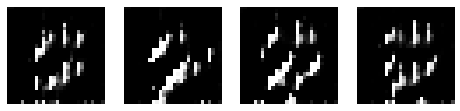

100%|██████████| 19/19 [00:00<00:00, 57.19it/s]


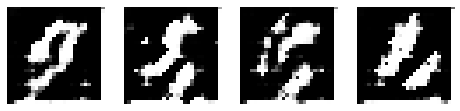

100%|██████████| 19/19 [00:00<00:00, 56.77it/s]


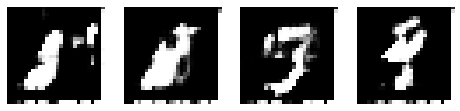

100%|██████████| 19/19 [00:00<00:00, 56.75it/s]


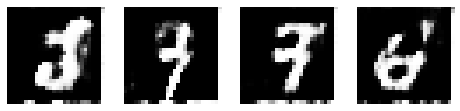

100%|██████████| 19/19 [00:00<00:00, 57.15it/s]


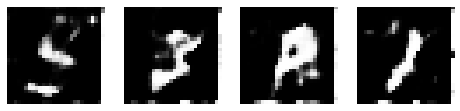

100%|██████████| 19/19 [00:00<00:00, 54.75it/s]


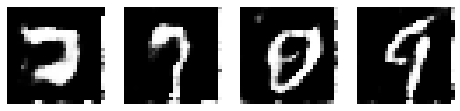

100%|██████████| 19/19 [00:00<00:00, 55.98it/s]


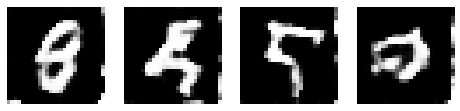

100%|██████████| 19/19 [00:00<00:00, 57.42it/s]


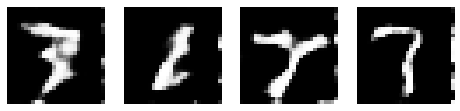

100%|██████████| 19/19 [00:00<00:00, 56.36it/s]


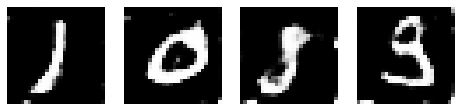

100%|██████████| 19/19 [00:00<00:00, 55.83it/s]


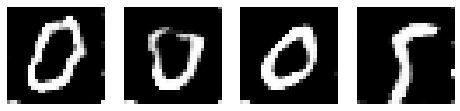

100%|██████████| 19/19 [00:00<00:00, 55.68it/s]


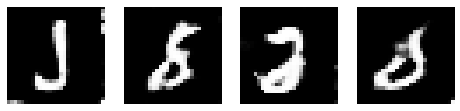

100%|██████████| 19/19 [00:00<00:00, 55.71it/s]


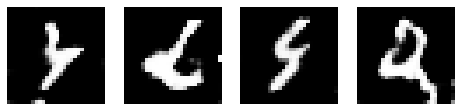

100%|██████████| 19/19 [00:00<00:00, 56.52it/s]


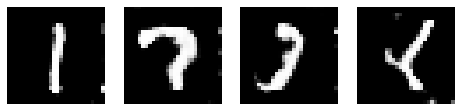

100%|██████████| 19/19 [00:00<00:00, 57.63it/s]


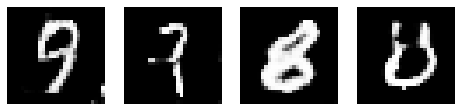

100%|██████████| 19/19 [00:00<00:00, 56.58it/s]


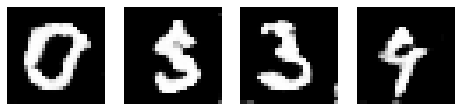

100%|██████████| 19/19 [00:00<00:00, 56.01it/s]


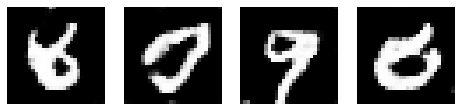

100%|██████████| 19/19 [00:00<00:00, 57.31it/s]


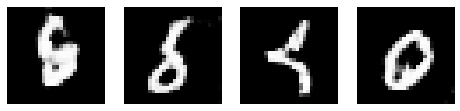

100%|██████████| 19/19 [00:00<00:00, 56.67it/s]


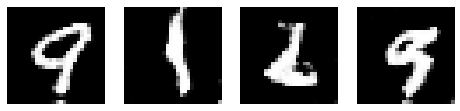

100%|██████████| 19/19 [00:00<00:00, 56.38it/s]


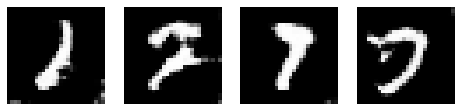

100%|██████████| 19/19 [00:00<00:00, 57.59it/s]


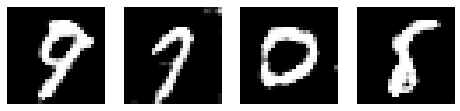

100%|██████████| 19/19 [00:00<00:00, 56.45it/s]


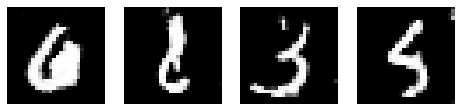

100%|██████████| 19/19 [00:00<00:00, 55.57it/s]


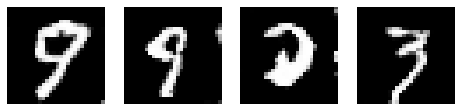

100%|██████████| 19/19 [00:00<00:00, 55.42it/s]


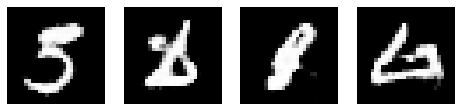

100%|██████████| 19/19 [00:00<00:00, 55.95it/s]


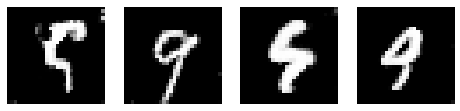

100%|██████████| 19/19 [00:00<00:00, 56.19it/s]


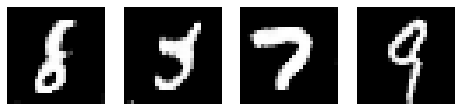

100%|██████████| 19/19 [00:00<00:00, 56.89it/s]


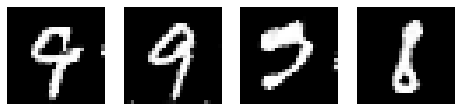

100%|██████████| 19/19 [00:00<00:00, 57.65it/s]


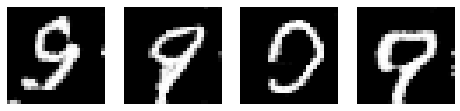

100%|██████████| 19/19 [00:00<00:00, 55.91it/s]


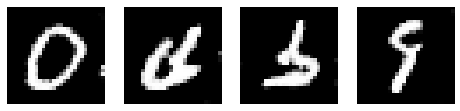

100%|██████████| 19/19 [00:00<00:00, 56.00it/s]


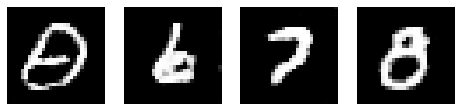

100%|██████████| 19/19 [00:00<00:00, 55.96it/s]


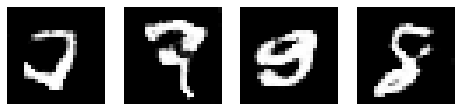

100%|██████████| 19/19 [00:00<00:00, 54.13it/s]


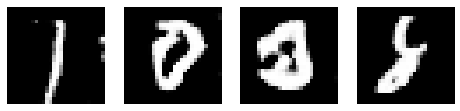

100%|██████████| 19/19 [00:00<00:00, 57.62it/s]


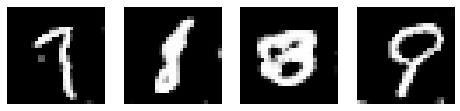

100%|██████████| 19/19 [00:00<00:00, 56.25it/s]


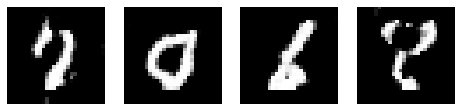

100%|██████████| 19/19 [00:00<00:00, 55.37it/s]


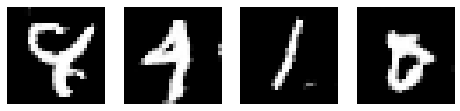

100%|██████████| 19/19 [00:00<00:00, 55.81it/s]


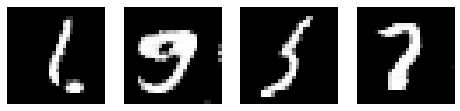

100%|██████████| 19/19 [00:00<00:00, 56.53it/s]


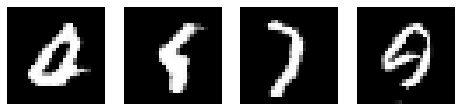

100%|██████████| 19/19 [00:00<00:00, 58.11it/s]


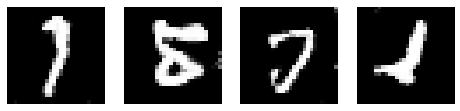

100%|██████████| 19/19 [00:00<00:00, 56.53it/s]


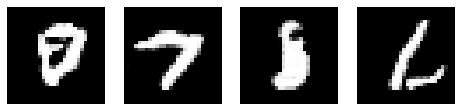

100%|██████████| 19/19 [00:00<00:00, 56.93it/s]


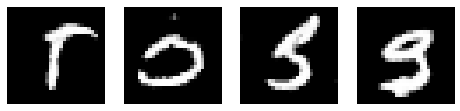

100%|██████████| 19/19 [00:00<00:00, 56.28it/s]


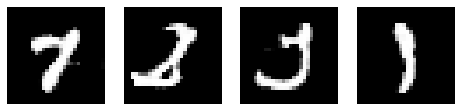

100%|██████████| 19/19 [00:00<00:00, 56.13it/s]


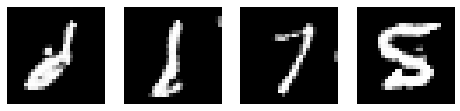

100%|██████████| 19/19 [00:00<00:00, 55.01it/s]


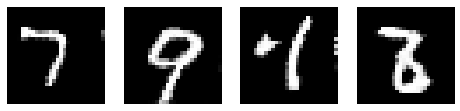

100%|██████████| 19/19 [00:00<00:00, 56.14it/s]


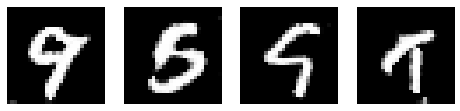

100%|██████████| 19/19 [00:00<00:00, 55.23it/s]


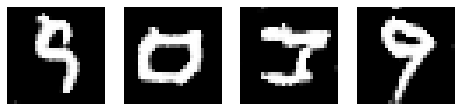

100%|██████████| 19/19 [00:00<00:00, 55.42it/s]


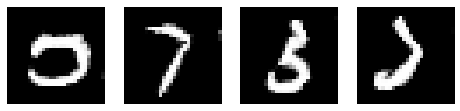

100%|██████████| 19/19 [00:00<00:00, 57.15it/s]


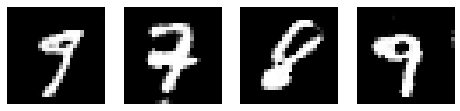

100%|██████████| 19/19 [00:00<00:00, 56.31it/s]


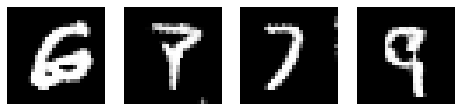

100%|██████████| 19/19 [00:00<00:00, 56.60it/s]


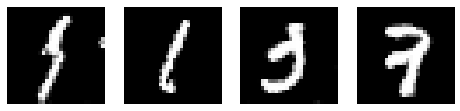

100%|██████████| 19/19 [00:00<00:00, 56.42it/s]


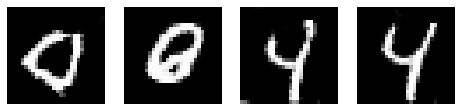

100%|██████████| 19/19 [00:00<00:00, 57.27it/s]


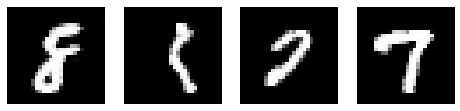

100%|██████████| 19/19 [00:00<00:00, 56.29it/s]


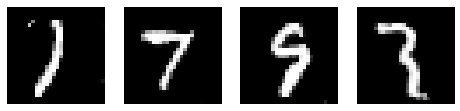

100%|██████████| 19/19 [00:00<00:00, 57.27it/s]


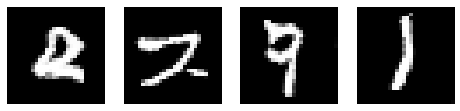

100%|██████████| 19/19 [00:00<00:00, 55.74it/s]


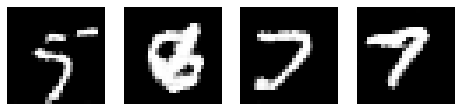

100%|██████████| 19/19 [00:00<00:00, 55.45it/s]


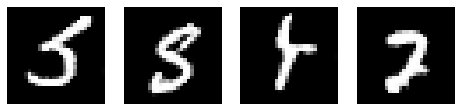

100%|██████████| 19/19 [00:00<00:00, 56.70it/s]


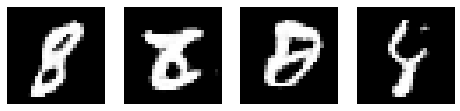

100%|██████████| 19/19 [00:00<00:00, 57.37it/s]


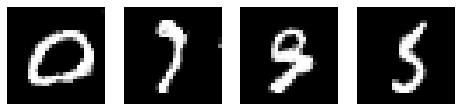

100%|██████████| 19/19 [00:00<00:00, 55.03it/s]


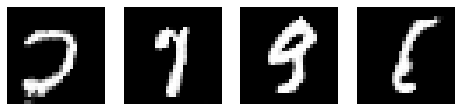

100%|██████████| 19/19 [00:00<00:00, 56.46it/s]


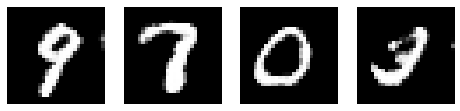

100%|██████████| 19/19 [00:00<00:00, 55.81it/s]


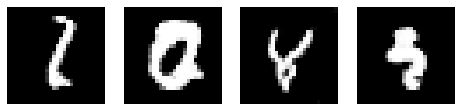

100%|██████████| 19/19 [00:00<00:00, 56.30it/s]


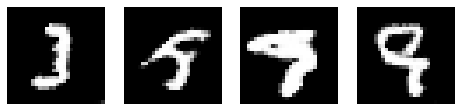

100%|██████████| 19/19 [00:00<00:00, 53.93it/s]


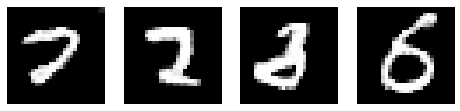

100%|██████████| 19/19 [00:00<00:00, 57.04it/s]


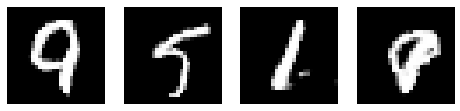

100%|██████████| 19/19 [00:00<00:00, 57.74it/s]


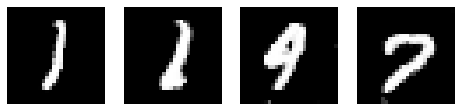

100%|██████████| 19/19 [00:00<00:00, 57.47it/s]


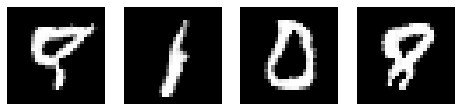

100%|██████████| 19/19 [00:00<00:00, 56.68it/s]


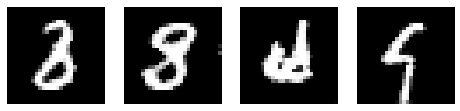

100%|██████████| 19/19 [00:00<00:00, 54.75it/s]


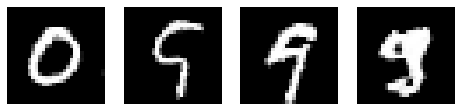

100%|██████████| 19/19 [00:00<00:00, 55.10it/s]


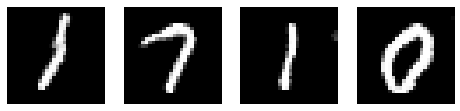

100%|██████████| 19/19 [00:00<00:00, 55.44it/s]


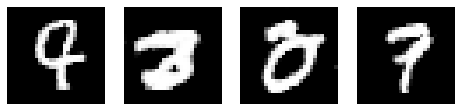

100%|██████████| 19/19 [00:00<00:00, 53.55it/s]


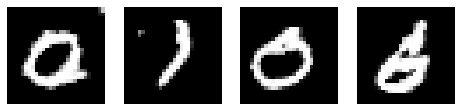

100%|██████████| 19/19 [00:00<00:00, 55.99it/s]


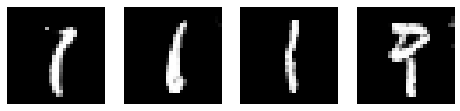

100%|██████████| 19/19 [00:00<00:00, 55.52it/s]


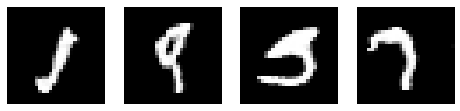

100%|██████████| 19/19 [00:00<00:00, 56.29it/s]


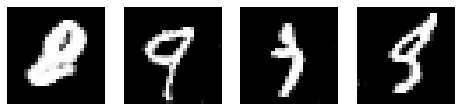

100%|██████████| 19/19 [00:00<00:00, 54.73it/s]


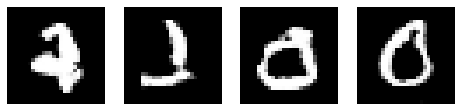

100%|██████████| 19/19 [00:00<00:00, 55.37it/s]


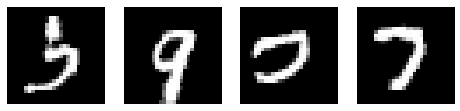

100%|██████████| 19/19 [00:00<00:00, 55.27it/s]


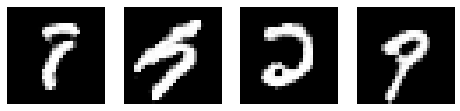

100%|██████████| 19/19 [00:00<00:00, 55.33it/s]


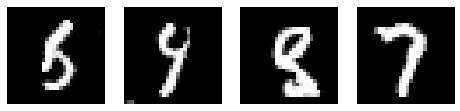

100%|██████████| 19/19 [00:00<00:00, 56.33it/s]


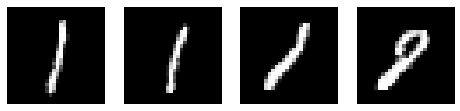

100%|██████████| 19/19 [00:00<00:00, 55.36it/s]


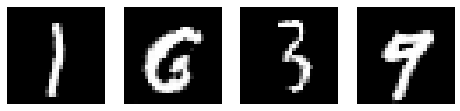

100%|██████████| 19/19 [00:00<00:00, 53.90it/s]


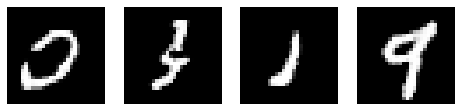

100%|██████████| 19/19 [00:00<00:00, 54.04it/s]


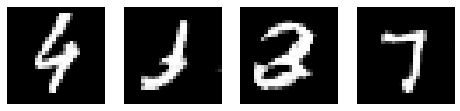

100%|██████████| 19/19 [00:00<00:00, 57.80it/s]


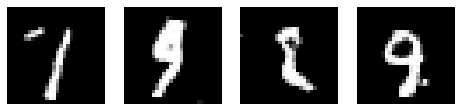

100%|██████████| 19/19 [00:00<00:00, 53.98it/s]


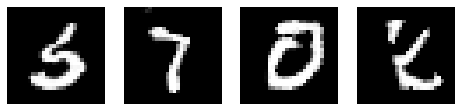

100%|██████████| 19/19 [00:00<00:00, 55.09it/s]


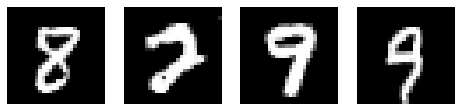

100%|██████████| 19/19 [00:00<00:00, 54.54it/s]


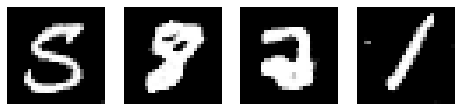

100%|██████████| 19/19 [00:00<00:00, 57.00it/s]


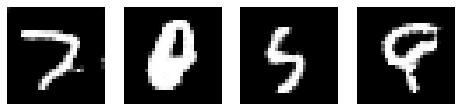

100%|██████████| 19/19 [00:00<00:00, 55.31it/s]


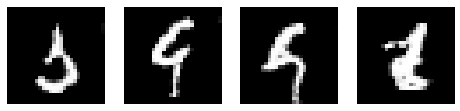

100%|██████████| 19/19 [00:00<00:00, 55.32it/s]


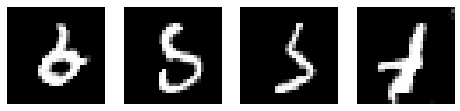

100%|██████████| 19/19 [00:00<00:00, 55.76it/s]


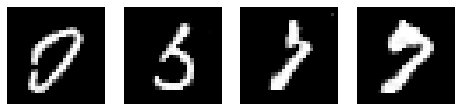

100%|██████████| 19/19 [00:00<00:00, 55.92it/s]


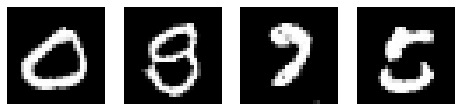

100%|██████████| 19/19 [00:00<00:00, 54.94it/s]


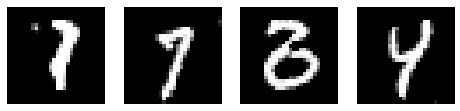

100%|██████████| 19/19 [00:00<00:00, 54.84it/s]


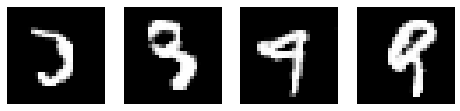

100%|██████████| 19/19 [00:00<00:00, 57.31it/s]


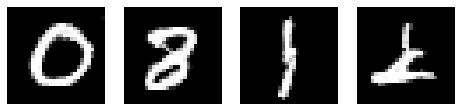

100%|██████████| 19/19 [00:00<00:00, 57.42it/s]


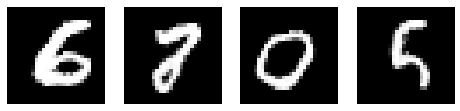

100%|██████████| 19/19 [00:00<00:00, 54.45it/s]


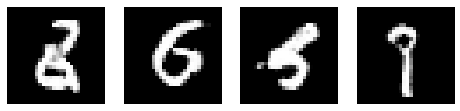

100%|██████████| 19/19 [00:00<00:00, 55.34it/s]


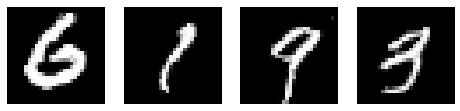

100%|██████████| 19/19 [00:00<00:00, 54.81it/s]


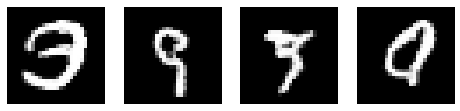

100%|██████████| 19/19 [00:00<00:00, 57.11it/s]


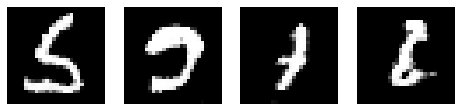

100%|██████████| 19/19 [00:00<00:00, 56.05it/s]


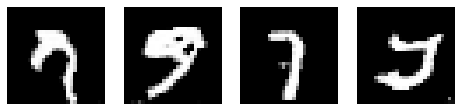

100%|██████████| 19/19 [00:00<00:00, 56.30it/s]


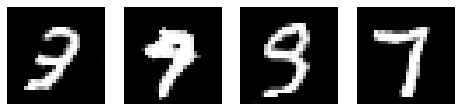

100%|██████████| 19/19 [00:00<00:00, 55.19it/s]


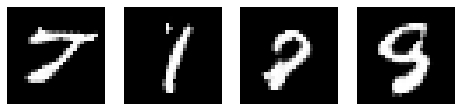

In [181]:
n_epochs = 100
for epoch in range(n_epochs):
    # Train
    for batch, train_x in tqdm(zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES):
        model.train(train_x)
    # Compute losses
    loss = []
    for batch, test_x in tqdm(zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # Plot results
    plot_reconstruction(model)

*Plot losses*

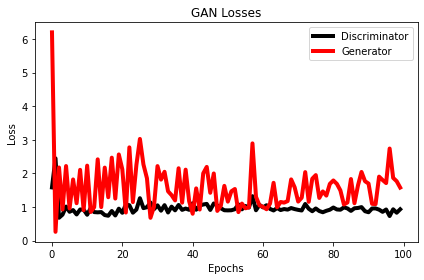

In [182]:
plt.figure()
plt.plot(losses['disc_loss'], 'k', linewidth=4, label='Discriminator')
plt.plot(losses['gen_loss'], 'r', linewidth=4, label='Generator')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('GAN Losses')
plt.legend()
plt.tight_layout()
plt.show()